## Introduction

The objective of this study is to determine the most popular style or genre of Steam's video games. Popularity is gauged by considering either the genre's playerbase, measured by the number of active players, or the sheer volume of games associated with that genre. The ultimate aim of this project is to streamline the game development process by identifying a genre which eliminates one of the crucial steps in creating a successful video game.

In [15]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

## Data Preprocessing

**Converts the format of the release dates to a more database-friendly style**

The original dates were formatted as "Jan 1, 2000" in Steam's API which was then converted to a more database-friendly style of "2000-01-01". Occasionally, the scraping program encountered games without a release date in which case the program will store its release date as "-1" in the SQL table. Variations of "Coming Soon", "To be released", or simply the year of the release date were other rare date formats. 

In [16]:
with sqlite3.connect('video_game_data_db.sqlite') as conn:

    # Converts the release_date format from "Jan 1, 2021" to "2021-01-01"
    conn.execute(
        """
        UPDATE game
        SET release_date = 

            substr(release_date, -4) 
            || '-' || 
            CASE 
                WHEN substr(release_date, 1, 3) = 'Jan' THEN '01'
                WHEN substr(release_date, 1, 3) = 'Feb' THEN '02'
                WHEN substr(release_date, 1, 3) = 'Mar' THEN '03'
                WHEN substr(release_date, 1, 3) = 'Apr' THEN '04'
                WHEN substr(release_date, 1, 3) = 'May' THEN '05'
                WHEN substr(release_date, 1, 3) = 'Jun' THEN '06'
                WHEN substr(release_date, 1, 3) = 'Jul' THEN '07'
                WHEN substr(release_date, 1, 3) = 'Aug' THEN '08'
                WHEN substr(release_date, 1, 3) = 'Sep' THEN '09'
                WHEN substr(release_date, 1, 3) = 'Oct' THEN '10'
                WHEN substr(release_date, 1, 3) = 'Nov' THEN '11'
                WHEN substr(release_date, 1, 3) = 'Dec' THEN '12'
            END 
            || '-' ||
            CASE 
                WHEN length(release_date) = 11 THEN '0' || substr(release_date, 5, 1)
                WHEN length(release_date) = 12 THEN substr(release_date, 5, 2)
            END
        WHERE release_date LIKE '%,%'
        """
    )

    conn.commit()

**Converts the format of the price to a more database-friendly format**

The '$' in the price column was removed. The leftover numbers were then converted to a DECIMAL type.

In [17]:
with sqlite3.connect('video_game_data_db.sqlite') as conn:
    conn.execute(
        """
        UPDATE game
        SET price = 
            CASE
                WHEN substr(price, 1, 1) = '$' THEN CAST(substr(price, 2) AS DECIMAL(15, 4))
                ELSE price
            END
        """
    )

    conn.commit()

## Basic Data Analysis 

A majority (20,000 games) of Steam games have less than 1,000 players. More shockingly, roughly 55,000 Steam games have 0 active players. 

In [18]:
with sqlite3.connect('video_game_data_db.sqlite') as conn:
    cur = conn.cursor()

    cur.execute("""
                 SELECT COUNT(*)
                 FROM game
                 JOIN player_count ON player_count.id = game.id
                 WHERE "09_06_1300" = 0
                 """)
    
    zero_playerbase = cur.fetchone()[0]

print(f"There are {zero_playerbase} games with 0 active players.")

There are 56946 games with 0 active players.


## Game Distribution Analysis

**Player distribution list created for data visualization below**

In [19]:
with sqlite3.connect('video_game_data_db.sqlite') as conn:
    cur = conn.cursor()

    # Games whose release dates and prices are invalid are already filtered out
    # from the scraping process
    cur.execute("""
                SELECT "09_06_1300" 
                FROM player_count 
                WHERE ("09_06_1300" BETWEEN 100 AND 1000)
                """)
    players_lt_200 = [player[0] for player in cur.fetchall()]
    
    cur.execute("""
                SELECT "09_06_1300" 
                FROM player_count 
                WHERE "09_06_1300" BETWEEN 1 AND 100
                """)
    all_players = [player[0] for player in cur.fetchall()]

**Displays the distribution of Steam games with varying playerbases**

A vast majority of Steam games have less than 100 active players. On the other hand, the games Counter-Strike 2, Team Fortress 2, and Dota 2 have over 100,000 concurrent players because of its competitive nature; they require multiple players to compete with one another. Games that require multiple players will always remain on top of the playerbase hierarchy. However, this does not mean that games without the multiplayer trait will have no playerbase. Other factors such as the lack of advertisement, substandard player feedback, or simply poor game development can result in a small playerbase and vise versa. Unfortunately, many of these games, approximately 60,000 of the 90,000 Steam games, have 0 active players. 

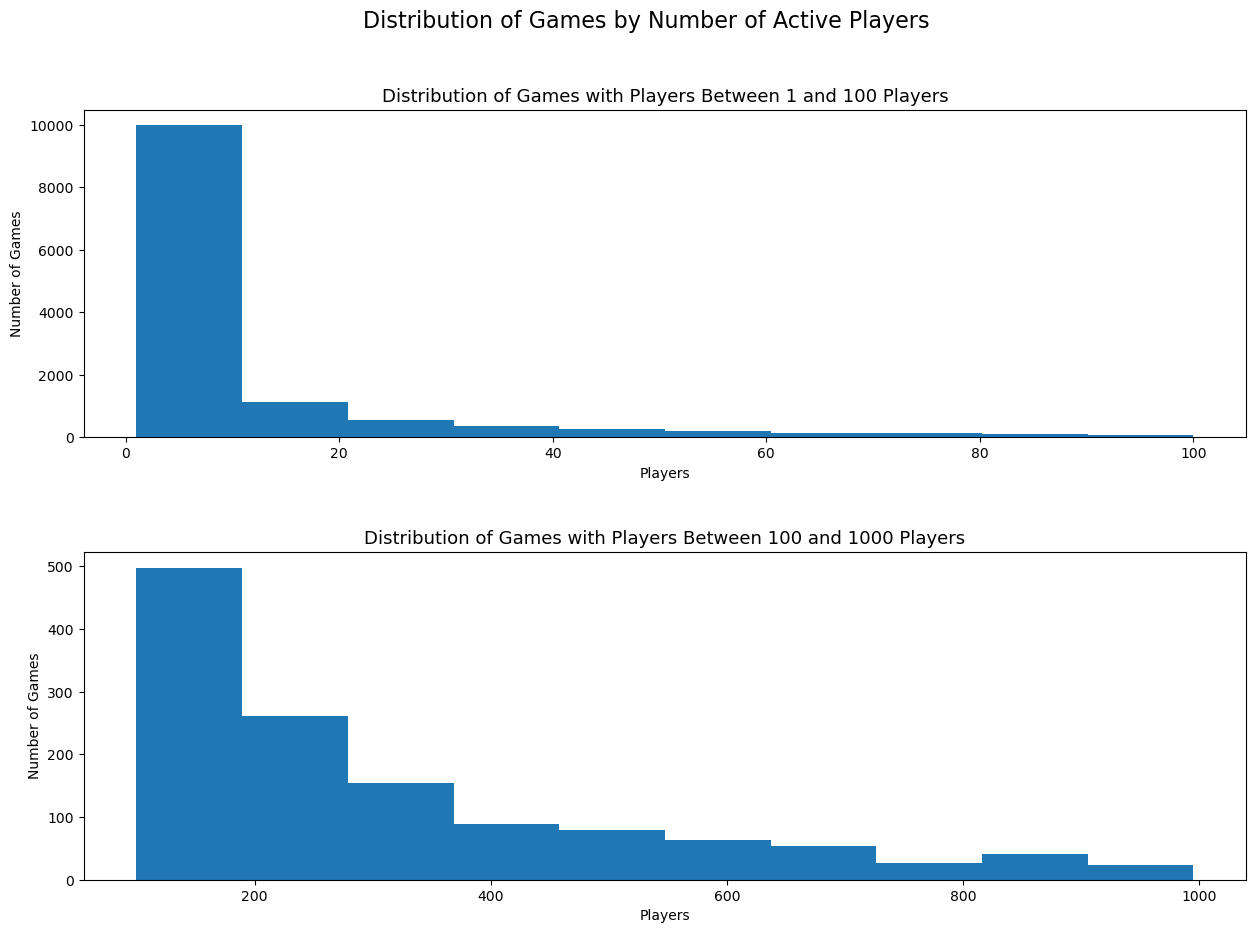

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
fig.suptitle("Distribution of Games by Number of Active Players", fontsize=16)

ax1.hist(all_players)
ax1.set_title("Distribution of Games with Players Between 1 and 100 Players", size=13)
ax1.set_xlabel("Players")
ax1.set_ylabel("Number of Games")


ax2.hist(players_lt_200)
ax2.set_title("Distribution of Games with Players Between 100 and 1000 Players", size=13)
ax2.set_xlabel("Players")
ax2.set_ylabel("Number of Games");

plt.subplots_adjust(hspace=0.35)

## Tag-Game_Count Analysis

**Tag-Game_Count table created for data visualization below**

In [21]:
# Created a table with columns release_year, tag_name, 
# and the number of games associated with that tag
with sqlite3.connect('video_game_data_db.sqlite') as conn:

    query = """
            SELECT substr(game.release_date, 1, 4) AS release_year, tag.name AS tag_name, COUNT(*) AS game_count
            FROM game_tag
            JOIN tag ON game_tag.tag_id = tag.id
            JOIN game ON game_tag.game_id = game.id
            WHERE 
                CAST(substr(game.release_date, 1, 4) AS INT) BETWEEN 2006 AND 2022
                AND game.price != -1
            GROUP BY substr(game.release_date, 1, 4), tag.name
            """
    
    date_tag_gamecount = pd.read_sql(query, conn)

date_tag_gamecount.sample(5, random_state=42)

,release_year,tag_name,game_count
5365,2021,Split Screen,75
4325,2019,Heist,7
199,2007,CRPG,1
3259,2016,Third Person,110
3493,2017,Indie,3793


**Displays the top 5 tags (genres) with the most games from 2006 to 2022**

The top 5 tags were determined with a simple linear regression model which calculated a best fit line for the change in number of released games per tag from the years 2006 to 2022. The tags with the largest slope (greatest increase in number of games) were displayed in the graph below. As seen, the tags (genres) Indie, Casual, Action, Adventure, and 2D were the most grossing produced style of games. The tags 'Singleplayer' and 'Multiplayer' were removed from the pool of tags because these two tags are nearly associated with all Steam games.

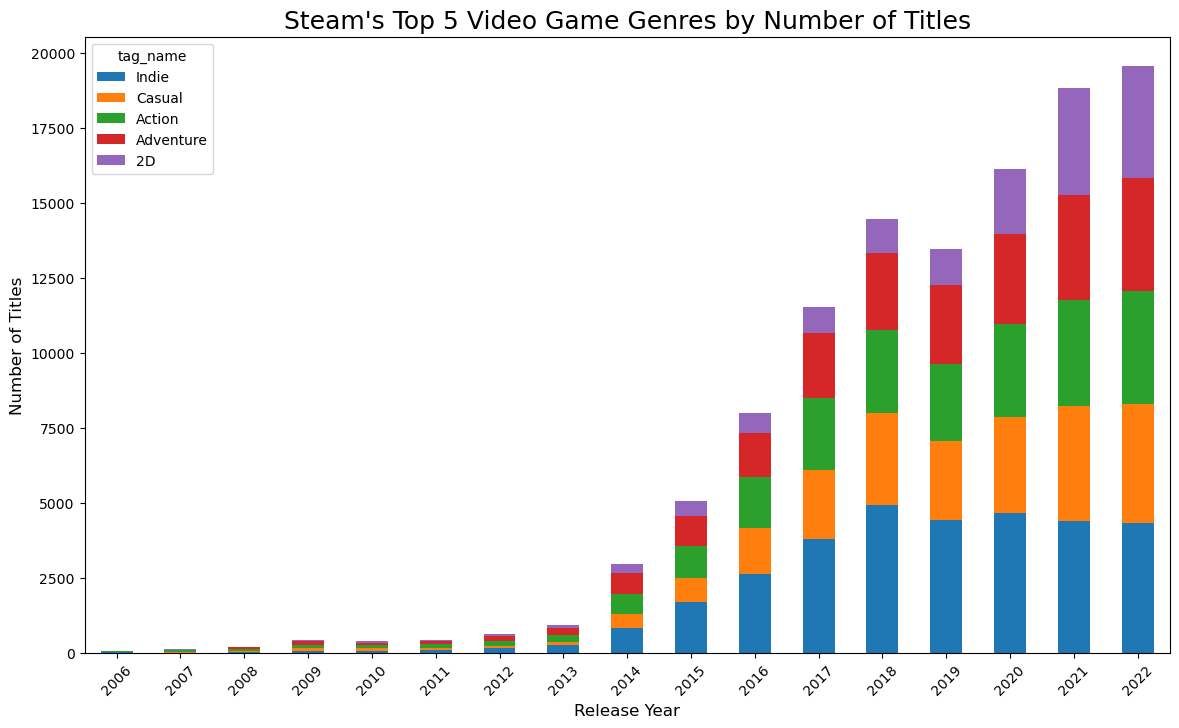

In [22]:
from sklearn.linear_model import LinearRegression

date_tag_gamecount_pivot = date_tag_gamecount.pivot(index='release_year', columns='tag_name', values='game_count')

date_tag_gamecount_pivot.fillna(0, inplace=True)

# Create a dictionary which will be converted to a dataframe
tag_count_slopes = {'tag_name': [], 'game_count': []}
for tag in date_tag_gamecount_pivot.columns:
    X = date_tag_gamecount_pivot.index.values.reshape(-1, 1) # dates
    y = date_tag_gamecount_pivot[tag].values # number of games

    # Linear Regression Model to find slope
    model = LinearRegression()
    model.fit(X, y)

    # Change in the number of games per year
    slope = round(model.coef_[0], 2) 

    tag_count_slopes['tag_name'].append(tag)
    tag_count_slopes['game_count'].append(slope)


# Sorting the dataframe by game count
tag_count_slopes = pd.DataFrame(tag_count_slopes)

# Filters out the 'Singleplayer' and 'Multiplayer' tags from the dataframe 
drop_labels = ['Singleplayer', 'Multiplayer']
tag_count_slopes = tag_count_slopes[~tag_count_slopes['tag_name'].isin(drop_labels)]
tag_count_slopes = tag_count_slopes.sort_values(by='game_count', ascending=False) # sorting

# Top 5 tags with the largest game count
top_n_tags = 5
top_tags_by_gamecount = tag_count_slopes['tag_name'][0:top_n_tags]


# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
date_tag_gamecount_pivot[top_tags_by_gamecount].plot(kind='bar', stacked=True, ax=ax)
ax.set_title("Steam's Top 5 Video Game Genres by Number of Titles", size=18)
ax.set_xlabel("Release Year", size=12)
ax.set_xticklabels(labels=date_tag_gamecount_pivot.index, rotation=45)
ax.set_ylabel("Number of Titles", size=12);

## Tag_playerbase Analysis

**Tag_playercount table created for data visualization below**

In [23]:
# Created a table with the columns tag_name and its weighted average of players (wavg_players)
with sqlite3.connect('video_game_data_db.sqlite') as conn:
    query = """
            WITH total_games AS (
            SELECT COUNT(*) AS total
            FROM game
            WHERE 
                CAST(substr(release_date, 1, 4) AS INT) >= 2006
                AND price != -1
            )

            SELECT tag.name AS tag_name, SUM("09_06_1300") * COUNT(*) / total_games.total AS wavg_players
            FROM game_tag, total_games
            JOIN tag ON tag.id = game_tag.tag_id
            JOIN game ON game.id = game_tag.game_id
            JOIN player_count ON player_count.id = game_tag.game_id
            WHERE 
                CAST(substr(release_date, 1, 4) AS INT) BETWEEN 2006 AND 2022
                AND price != -1
            GROUP BY tag.name
            """

    tag_playercount = pd.read_sql(query, con=conn)

tag_playercount.set_index('tag_name', inplace=True)
drop_labels = ['Singleplayer', 'Multiplayer'] # irrelevant tags to drop
top_n_tags = 5 # number of tags to consider

# Sort the table by average player count (highest to lowest)
tag_playercount = tag_playercount.sort_values(by='wavg_players', ascending=False)
top_tags_by_playercount = tag_playercount.drop(labels=drop_labels)[0:top_n_tags]

**Displays the top 5 genres with the largest average playerbase**

The 5 video games genre by average player count in descending order are action, indie, adventure, simulation, and strategy. This is expected because the genre of games that were created the most in the recent years were also indie and action.  

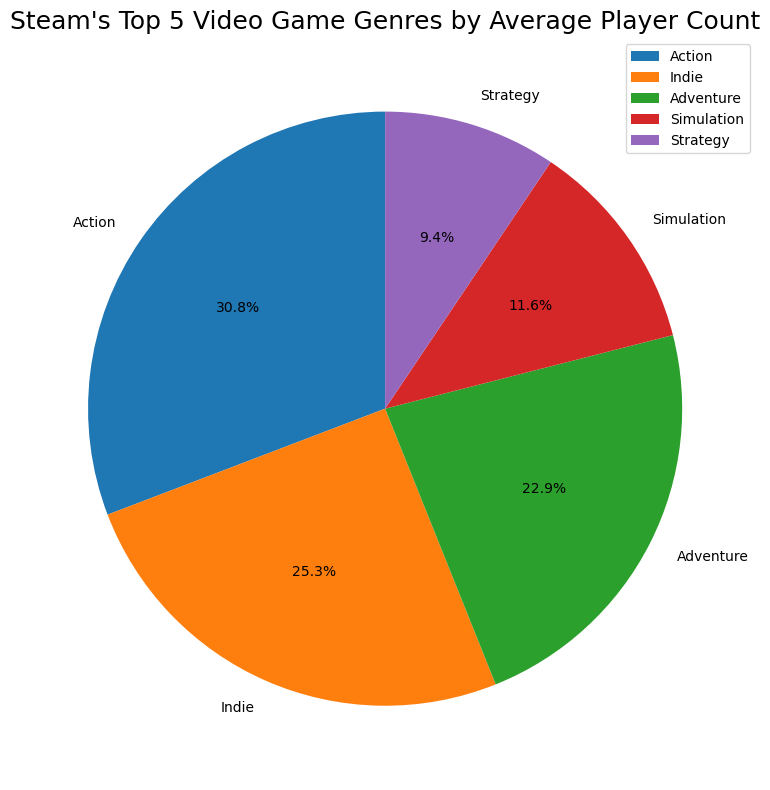

In [24]:
# Plotting
fig, ax = plt.subplots(figsize=(15,8))
top_tags_by_playercount.plot.pie(
    y='wavg_players',
    autopct='%1.1f%%',
    ax=ax,
    startangle=90
);
ax.set_title("Steam's Top 5 Video Game Genres by Average Player Count", size=18)
ax.set_ylabel('')
ax.set_xlabel('')

plt.tight_layout()

**Table with the release date, tag, and price for the data visualization below**

In [25]:
with sqlite3.connect('video_game_data_db.sqlite') as conn:
    query = """
            SELECT substr(release_date, 1, 4) AS release_year, tag.name AS tag_name, SUM(price) AS avg_price
            FROM game_tag
            JOIN tag ON tag.id = game_tag.tag_id
            JOIN game ON game.id = game_tag.game_id
            WHERE 
                CAST(substr(release_date, 1, 4) AS INT) >= 2006 
                AND price != -1
            GROUP BY substr(release_date, 1, 4), tag.name
            """
    
    query = """  
            SELECT game.id, game.name, substr(release_date, 1, 4) AS release_year, tag.name AS tag_name, AVG(price) AS avg_price
            FROM game_tag
            JOIN tag ON tag.id = game_tag.tag_id
            JOIN game ON game.id = game_tag.game_id
            JOIN player_count ON player_count.id = game.id
            WHERE 
                "09_06_1300" >= 20 
                AND (CAST(substr(release_date, 1, 4) AS INT) BETWEEN 2006 AND 2022)
                AND price != -1
            GROUP BY substr(release_date, 1, 4), tag.name
            ORDER BY release_year DESC
            """
    
    date_tag_price = pd.read_sql(query, con=conn)

date_tag_price_pivot = date_tag_price.pivot(index='release_year', columns='tag_name', values='avg_price')

date_tag_price_pivot.fillna(0, inplace=True)

date_tag_price_pivot.head()

tag_name,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,3D,3D Fighter,3D Platformer,3D Vision,...,Warhammer 40K,Well-Written,Werewolves,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies
release_year,,,,,,,,,,,,,,,,,,,,,
2006,0.0,0.000000,0.00,4.99,0.0,0.00,9.990000,0.0,9.99,9.990000,...,0.00,0.00,0.0,0.00,0.0,0.0,0.00,19.990000,0.0,13.990000
2007,0.0,4.597143,1.99,4.99,0.0,0.00,0.000000,0.0,3.98,0.980000,...,12.99,0.00,0.0,0.00,0.0,0.0,0.00,10.390000,0.0,7.990000
2008,0.0,4.990000,0.00,4.99,0.0,0.00,19.990000,0.0,0.98,0.980000,...,12.99,0.00,0.0,0.00,0.0,0.0,0.00,12.490000,0.0,12.490000
2009,0.0,9.990000,0.00,10.49,0.0,0.00,11.656667,0.0,19.99,19.990000,...,19.99,0.00,0.0,9.99,0.0,0.0,9.99,11.590000,0.0,13.323333
2010,0.0,5.990000,0.00,15.24,0.0,14.99,0.000000,0.0,19.99,18.323333,...,19.99,29.99,0.0,2.49,0.0,0.0,19.99,9.156667,0.0,26.656667


**Displays the change in price of Steam games which are grouped by their tags**

As seen below, the cost of games have gradually increased from $10 to $25. This can be due to various economical reasons or simply the overall improvement in quality of Steam games. The price of the Indie and Casual tag have one of the lowest prices in the present day which is logical because they are primarily created by independent game developers or small indie game studios.

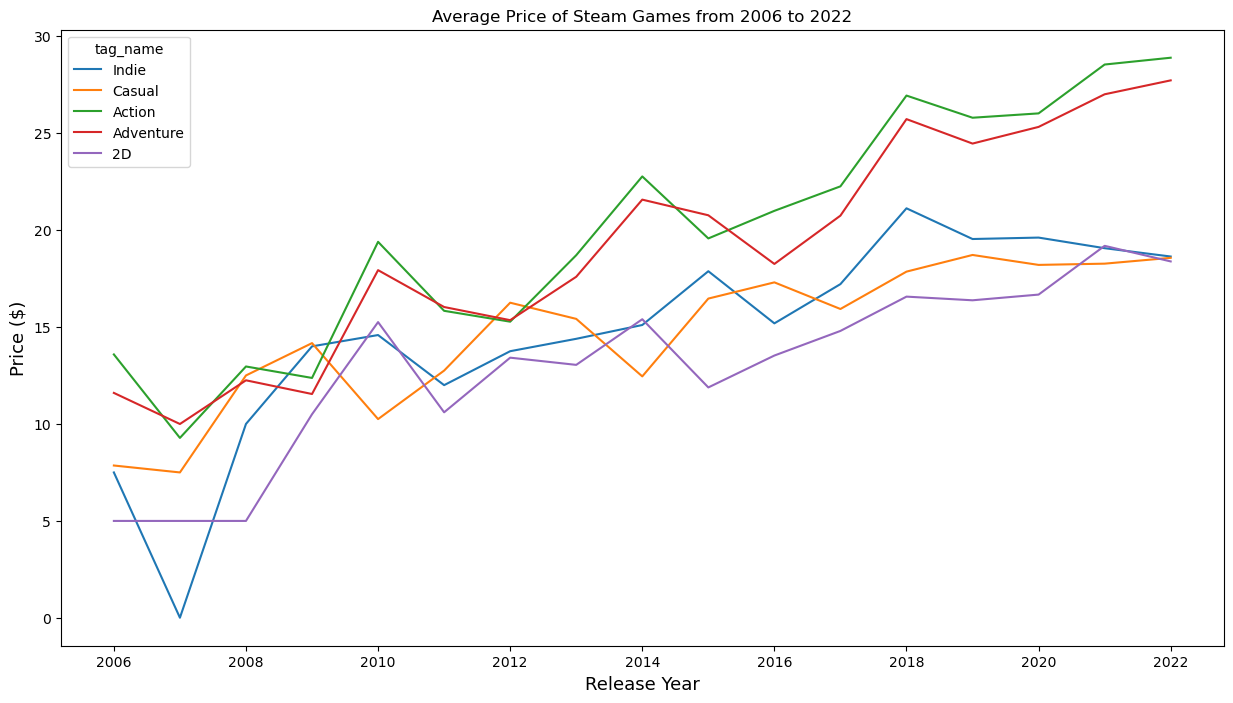

In [26]:
# Plotting
fig, ax = plt.subplots(figsize=(15,8))
date_tag_price_pivot[top_tags_by_gamecount].plot(kind='line', ax=ax)

ax.set_title("Average Price of Steam Games from 2006 to 2022")
ax.set_xlabel("Release Year", size=13)
ax.set_ylabel("Price ($)", size=13);

### Conclusion

Game developers should create indie, action, or strategical-styled games or a mixture because of their consistent rise in popularity in both playerbase and the shear number of games created. However, it's important to consider external factors besides the genre that would also increase the game's playerbase such as advertising, optimal price points, release time, and especially player feedback from alpha and beta tests. The price point for a typical indie game should be in the range of $15 to $20 as indicated in the price analysis of video game genres over the years. With one obstacle out of the way, you will be one step closer in creating a popular Steam game.